In [1]:
from keras.datasets import imdb

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

num_words는 훈련 데이터에서 가장 많이 나타나는 단어 10000개를 사용하겠다는 뜻
각 labels에 저장된 0과 1은 0:부정 , 1:긍정으로 카테고리 변수로 사용할 수 있음

In [3]:
max([max(sequence) for sequence in train_data])

9999

In [4]:
train_data.shape

(25000,)

In [5]:
len(train_data[24999])

153

In [6]:
word_index = imdb.get_word_index()    # 단어와 정수 인덱스를 매핑한 딕셔너리
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

신경망에 숫자 리스트를 넣을 수는 없다.

리스트를 텐서로 바꾸는 방법은 두 가지.

1. 같은 길이가 되도록 리스트에 패딩을 추가하고 (samples, sequence_length) 크기의 정수 텐서로 변환한다. 그다음 이 정수 텐서를 다룰 수 있는 층을 신경망의 첫 번째 층으로 사용한다.
2. 리스트를 원-핫 인코딩하여 0과 1의 벡터로 변환한다. 예를 들어 시퀀스[3,5]를 인덱스 3과 5의 위치는 1이고 나머지는 0인 10000차원의 벡터로 각각 변환한다. 그다음 부동 소수 벡터 데이터를 다룰 수 있는 Dense 층을 신경망의 첫 번째 층으로 사용한다. 

In [7]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

In [8]:
X_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [9]:
X_test[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [10]:
# 데이터를 벡터화했으니 레이블도 벡터화 해야하는데, 레이블은 01로만 이루어져있으므로 numpy asarray 사용
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Dense 층을 쌓을 때 두 가지 중요한 구조상의 결정이 필요하다
1. 얼마나 많은 층을 사용할 것인가?
2. 각 층에 얼마나 많은 은닉 유닛을 둘 것인가?

해당 실습에서는 중간에 위치하는 은닉층은 활성화 함수로 relu를 사용, 마지막 층은 확률을 점수로 출력하기 위해 시그모이드 활성화 함수를 사용
1. relu는 음수를 0으로 만드는 함수
2. sigmoid는 0과 1 사이로 정규화하므로 출력값을 확률로 해석 가능

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Dense층의 매개변수 16은 은닉 유닛의 개수이다. 하나의 은닉 유닛은 층에 나타내는 표현 공간에서 하나의 차원이 된다. 16개의 은닉 유닛이 있다는 것은 가중치 행렬 $w$의 크기가 16차원이라는 것이다. 

model에 레이어를 만들어준 후에는,

옵티마이저와 손실함수를 정해줘야한다.

compile 메서드의 파라미터로 지정.

In [12]:
from keras import losses
from keras import metrics

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
# from keras import losses
# from keras import metrics

# model.compile(optimizer='rmsprop',
#               loss=losses.binary_crossentropy,
#               metrics=[metrics.binary_accuracy])

# 손실함수나 측정함수에도 직접 값을 전달하고 싶은 경우, 클래스를 직접 불러와서 함수 객체를 전달하면 됨

# 훈련 검증
- 훈련하는 동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해서는 원본 훈련 데이터에서 10,000의 샘플을 떼어서 검증 세트를 만들어야 함.

In [14]:
x_val = X_train[:10000]
partial_X_train = X_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [15]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 23ms/step - loss: 0.5901 - accuracy: 0.6305 - val_loss: 0.5186 - val_accuracy: 0.7910
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.4640 - accuracy: 0.8537 - val_loss: 0.4629 - val_accuracy: 0.8592
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.3903 - accuracy: 0.9101 - val_loss: 0.4095 - val_accuracy: 0.8893
Epoch 4/20
30/30 [==============================] - ETA: 0s - loss: 0.3118 - accuracy: 0.93 - 0s 12ms/step - loss: 0.3099 - accuracy: 0.9391 - val_loss: 0.3817 - val_accuracy: 0.8685
Epoch 5/20
30/30 [==============================] - 0s 11ms/step - loss: 0.2360 - accuracy: 0.9529 - val_loss: 0.3300 - val_accuracy: 0.8846
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1799 - accuracy: 0.9606 - val_loss: 0.3080 - val_accuracy: 0.8845
Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1406 - accuracy: 0.9691 - val_loss: 0

fit() 메서드는 history 객체를 반환한다. 훈련간 발생한 정보를 담고 있는 history를 열어서 확인해볼 수 있음.

history 객체를 이용하여 에포크 별 변화를 시각화할 수 있음.

In [16]:
history_dict = history.history
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [17]:
history.history.get('loss')

[0.5900672674179077,
 0.4639810621738434,
 0.3903041481971741,
 0.3098899722099304,
 0.23598171770572662,
 0.1799011379480362,
 0.1405818611383438,
 0.11172544211149216,
 0.09228391200304031,
 0.07767090946435928,
 0.06335509568452835,
 0.05330895259976387,
 0.04262317717075348,
 0.03657012805342674,
 0.033031437546014786,
 0.022213716059923172,
 0.024965237826108932,
 0.015765052288770676,
 0.020081650465726852,
 0.011939231306314468]

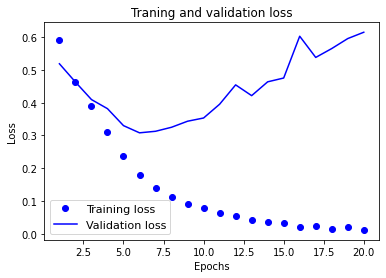

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

epochs = range(1, len(acc) + 1)

# 'bo'는 color = b, style = o 를 뜻함
plt.plot(epochs, loss, 'bo', label='Training loss')
# 'b'는 color = b, linestyle = '-'를 뜻함
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Traning and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize=11.2)

plt.show()

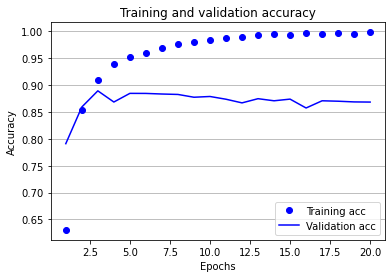

In [20]:
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(axis='y')

plt.show()

In [23]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(X_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 8ms/step - loss: 0.4831 - accuracy: 0.8127
Epoch 2/4
49/49 [==============================] - 0s 7ms/step - loss: 0.2762 - accuracy: 0.9068
Epoch 3/4
49/49 [==============================] - 0s 8ms/step - loss: 0.2094 - accuracy: 0.9254
Epoch 4/4
782/782 [==============================] - 1s 1ms/step - loss: 0.2912 - accuracy: 0.8838


In [24]:
results

[0.2912263870239258, 0.8838000297546387]

In [26]:
model.predict(X_test)

array([[0.1753377 ],
       [0.9993568 ],
       [0.83300185],
       ...,
       [0.11008233],
       [0.0575797 ],
       [0.5521012 ]], dtype=float32)